# Feature Engineering

### Import Libraries

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#feature engineering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

#Model Creation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

#hyperparameter tuning 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#warnings
from warnings import simplefilter

#evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

### Import data

In [2]:
final_df = pd.read_csv('data/final_df.csv',index_col = 0)

In [3]:
final_df.dtypes

Season                     int64
Week_Number                int64
Week_Name                 object
Baker                     object
Gender                    object
Age                        int64
Signature_Handshake        int64
Technical_Rank             int64
Showstopper_Handshake      int64
Favorite                 float64
Least_Favorite             int64
Star_Baker                 int64
Eliminated                 int64
Winner                     int64
signature                 object
showstopper               object
dtype: object

### Create a table of winners for future reference

In [4]:
Table_of_Winners = final_df.loc[final_df.Winner == 1]

In [5]:
Table_of_Winners = Table_of_Winners[['Season','Baker']].drop_duplicates()

In [6]:
Table_of_Winners.to_csv('data/Table_of_Winners.csv')

After understanding my data better:
- It seems the winner decided by whoever wins the final star baker. Therefore I will remove Winner from my dataset and set the target feature to Star Baker.
- Week_Name is redundant with Week_Number. I'll remove Week_Number
- We don't need the names of the bakers.
- Lastly, we will remove the name of the season, because older seasons won't show up in future datasets

### Drop Week_Number, Baker, Winner

In [7]:
df = final_df.drop(columns=['Week_Number','Baker','Winner','Season'])

In [8]:
df = df.astype({'Week_Name':'category',
                       'Gender':'category'})
df.dtypes

Week_Name                category
Gender                   category
Age                         int64
Signature_Handshake         int64
Technical_Rank              int64
Showstopper_Handshake       int64
Favorite                  float64
Least_Favorite              int64
Star_Baker                  int64
Eliminated                  int64
signature                  object
showstopper                object
dtype: object

In [9]:
df.head()

,Week_Name,Gender,Age,Signature_Handshake,Technical_Rank,Showstopper_Handshake,Favorite,Least_Favorite,Star_Baker,Eliminated,signature,showstopper
0,Cake,M,31,0,2,0,0.0,0,0,0,Rhubarb and Custard CupcakesAfter Dinner Cupcakes,Vanilla Sponge with White Chocolate and Raspbe...
1,Cake,F,31,0,1,0,0.0,0,1,0,Cherry Bakewell Inspired CupcakesGinger Cupcak...,Novelty Farm Cake
2,Cake,M,40,0,10,0,0.0,0,0,0,Apple and Cinnamon Cupcakes,Unknown
3,Cake,F,63,0,8,0,0.0,0,0,0,Raspberry and Cream Cupcakes,Chocolate Marble Cakewith Dark and White Choco...
4,Cake,M,19,0,6,0,0.0,0,0,0,Lemon Meringue CupcakesApple and Cinnamon Cupc...,Unknown


### Check for Class Imbalance

In [10]:
#is our class unbalanced?
#we should use SMOTE for class balance
df.Star_Baker.value_counts()

0    576
1     88
Name: Star_Baker, dtype: int64

<AxesSubplot:ylabel='Star_Baker'>

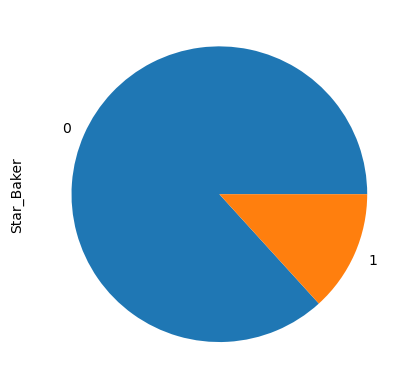

In [11]:
df.Star_Baker.value_counts().plot(kind='pie')

### Dealing with Class Imbalance

We will use 5 methods to deal with class imbalance
1. Do nothing 
2. set Stratify = y to maintain our class ratios between the train/test/split
3. use SMOTE
4. use SMOTETomek
5. use TomekLinks

In [12]:
X = df.drop(columns='Star_Baker')
y= df['Star_Baker'].values

In [13]:
#Import necessary libraries
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

In [14]:
# We will not set stratify=y and test moethods 1,3,4 and 5 listed above. 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.30, random_state=0)

#create unique lists for our different transformed columns
num_cols = list(X_train.select_dtypes(include='number').columns)
cat_cols = list(X_train.select_dtypes(include='category').columns)
sig_text = ('signature')
show_text = ('showstopper')

#add the transformers
preprocessor = ColumnTransformer( 
    transformers = [
        
        ('num',StandardScaler(),num_cols),                         #scale the numerical values
        ('cat',OneHotEncoder(handle_unknown = 'ignore'),cat_cols), #encode the categorical features
        ('text_sig',TfidfVectorizer(max_features=50),sig_text),    #freq counts for words
        ('text_show',TfidfVectorizer(max_features=50),show_text)   #freq counts for words
    ], remainder='passthrough')


#fit and transform our data
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)




## SMOTE method 
s= SMOTE()
##SMOTETomek method
smt= SMOTETomek()
##TomekLinks method
tk= TomekLinks()

#resample our training data 
X_res, y_res= s.fit_resample(X_train_trans, y_train)
X_res1, y_res1= smt.fit_resample(X_train_trans, y_train)
X_res2, y_res2= tk.fit_resample(X_train_trans, y_train)



#create our lm model
lr_model = LogisticRegression()

print("Basic LR Model W/O Class Balancing")
lr_model.fit(X_train_trans,y_train)
ypred_basic=lr_model.predict(X_test_trans) 
print(classification_report(y_test,ypred_basic))
print('--------------------')

print("SMOTE TEST")
lr_model.fit(X_res, y_res)
ypred=lr_model.predict(X_test_trans)
print(classification_report(y_test,ypred))
print('--------------------')

print("SMOTETomek TEST")
lr_model.fit(X_res1, y_res1)
ypred1=lr_model.predict(X_test_trans)
print(classification_report(y_test,ypred1))
print('--------------------')
print("TomekLinks TEST")
lr_model.fit(X_res2, y_res2)
ypred2=lr_model.predict(X_test_trans)
print(classification_report(y_test,ypred2))

Basic LR Model W/O Class Balancing
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       174
           1       0.29      0.27      0.28        26

    accuracy                           0.82       200
   macro avg       0.59      0.59      0.59       200
weighted avg       0.81      0.82      0.82       200

--------------------
SMOTE TEST
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       174
           1       0.41      0.77      0.53        26

    accuracy                           0.82       200
   macro avg       0.68      0.80      0.71       200
weighted avg       0.89      0.82      0.85       200

--------------------
SMOTETomek TEST
              precision    recall  f1-score   support

           0       0.95      0.84      0.90       174
           1       0.41      0.73      0.53        26

    accuracy                           0.83       200
   macro avg       0.68 

In [15]:
# We will not set stratify=y and test moethod 2 listed above. 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.30, random_state=0,stratify=y)

#create unique lists for our different transformed columns
num_cols = list(X_train.select_dtypes(include='number').columns)
cat_cols = list(X_train.select_dtypes(include='category').columns)
sig_text = ('signature')
show_text = ('showstopper')

#add the transformers
preprocessor = ColumnTransformer( 
    transformers = [
        
        ('num',StandardScaler(),num_cols),                         #scale the numerical values
        ('cat',OneHotEncoder(handle_unknown = 'ignore'),cat_cols), #encode the categorical features
        ('text_sig',TfidfVectorizer(max_features=50),sig_text),    #freq counts for words
        ('text_show',TfidfVectorizer(max_features=50),show_text)   #freq counts for words
    ], remainder='passthrough')



X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

lr_model = LogisticRegression()

lr_model.fit(X_train_trans,y_train)

ypred_strat=lr_model.predict(X_test_trans)

print(classification_report(y_test,ypred_strat))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       173
           1       0.45      0.37      0.41        27

    accuracy                           0.85       200
   macro avg       0.68      0.65      0.66       200
weighted avg       0.84      0.85      0.85       200



Ranking these methods for f1-score since there isn't a big difference in False Positives or False negatives in this model

Ranking
1. SMOTETomek (0.55 f1)
2. SMOTE (0.54 f1)
3. TomekLinks (0.47 f1)
4. stratify/non-stratify (0.51 f1)


# Model Creation

Now that we know that we want to use SMOTETomke, let's trying subsituting models out to improve our model performance

## RandomForest

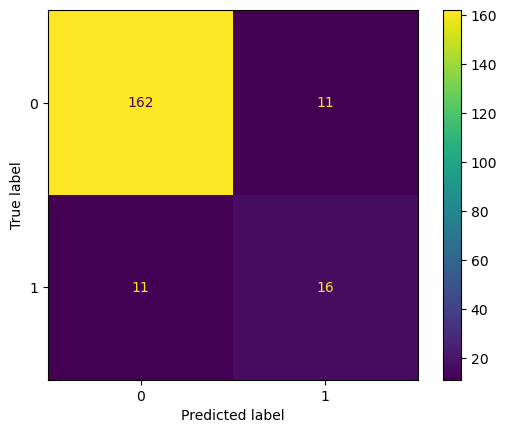

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       173
           1       0.59      0.59      0.59        27

    accuracy                           0.89       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.89      0.89      0.89       200

The training score for the random forest model is 1.0     
and the testing score for the model is 0.89


In [17]:
#Basic Random Forest with SMOTETomke
rf = RandomForestClassifier(random_state = 1, n_jobs=-1)

#fit
model =rf.fit(X_res1, y_res1)

#pred
y_pred = model.predict(X_test_trans)

#confusion matrix

cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()





print(classification_report(y_test,y_pred))

#scores

training_score = (rf.score(X_res1,y_res1))
testing_score = (rf.score(X_test_trans, y_test))
f1 = f1_score(y_pred, y_test)

print(f'The training score for the random forest model is {training_score}\
     \nand the testing score for the model is {testing_score}')

f1 score was raised to 0.67; much better. 

### Creating a table to store model outputs

In [18]:
Model_Data_Frame = pd.DataFrame({"Random Forest w/o CV": [training_score,testing_score,f1]})
index_name = ['Training','Testing','F1']
Model_Data_Frame.index=index_name
Model_Data_Frame

,Random Forest w/o CV
Training,1.000000
Testing,0.890000
F1,0.592593


Fitting 3 folds for each of 100 candidates, totalling 300 fits


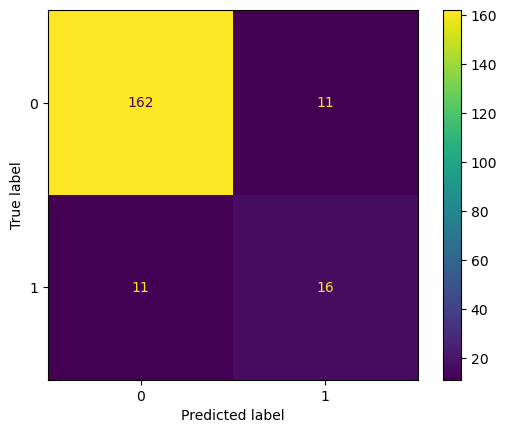

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       173
           1       0.59      0.59      0.59        27

    accuracy                           0.89       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.89      0.89      0.89       200



In [19]:
#Random Forest with SMOTETomke with hyperparameter tuning



rf = RandomForestClassifier(random_state = 1, n_jobs=-1)


#creating HP tuning Grid


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}





# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_res1, y_res1)

#pred
y_pred = model.predict(X_test_trans)
#confusion matrix
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

#evaluations
#report card
print(classification_report(y_test,y_pred))

#scores
training_score = (rf_random.score(X_res1,y_res1))
testing_score = (rf_random.score(X_test_trans, y_test))
f1 = f1_score(y_test,y_pred)

#add results to ur table
Model_Data_Frame['Random Forest (w/CV)']=[training_score,testing_score,f1]

## Logistic Regression

In [30]:
#Our original model used a LOGIT model so we can add directly to our table
lr_model.fit(X_res1, y_res1)
training_score = (lr_model.score(X_res1,y_res1))
testing_score = (lr_model.score(X_test_trans, y_test))
y_pred=lr_model.predict(X_test_trans)
f1 = f1_score(y_test,y_pred)



Model_Data_Frame['Logistic Regression (w/o CV)']=[training_score,testing_score,f1]

In [31]:
#LOGIT model with hyperparameter tuning

logreg = LogisticRegression()
param_grid = {'C':np.arange(.1,1.1,.1)}

logreg_cv =GridSearchCV(logreg,param_grid,cv=3)


logreg_cv.fit(X_res1,y_res1)
y_pred = logreg_cv.predict(X_test_trans)

print(classification_report(y_test,y_pred))
training_score = (logreg_cv.score(X_res1,y_res1))
testing_score = (logreg_cv.score(X_test_trans, y_test))
f1 = f1_score(y_pred, y_test)

Model_Data_Frame['Logistic Regression (w/ CV)']=[training_score,testing_score,f1]

              precision    recall  f1-score   support

           0       0.98      0.82      0.89       173
           1       0.43      0.89      0.58        27

    accuracy                           0.82       200
   macro avg       0.70      0.85      0.73       200
weighted avg       0.90      0.82      0.85       200



In [32]:
#LOGIT model with lasso regression

logreg_lasso = LogisticRegression(penalty='l1', solver='liblinear')
param_grid = {'C':np.arange(.1,1.1,.1)}

logreg_cv =GridSearchCV(logreg_lasso,param_grid,cv=3)


logreg_cv.fit(X_res1,y_res1)

y_pred = logreg_cv.predict(X_test_trans)

print(classification_report(y_test,y_pred))
training_score = (logreg_cv.score(X_res1,y_res1))
testing_score = (logreg_cv.score(X_test_trans, y_test))
f1 = f1_score(y_pred, y_test)

Model_Data_Frame['Logistic Regression (w/ CV & Lasso)']=[training_score,testing_score,f1]

#print out a list of important coefficients
Coef_Table = pd.DataFrame(zip(preprocessor.get_feature_names_out(),
                              logreg_cv.best_estimator_.coef_[0])).sort_values(1,ascending=False)
Coef_Table.columns=['feature','coef']
Coef_Table[Coef_Table.coef!=0].reset_index(drop=True).head()

              precision    recall  f1-score   support

           0       0.95      0.82      0.88       173
           1       0.39      0.74      0.51        27

    accuracy                           0.81       200
   macro avg       0.67      0.78      0.70       200
weighted avg       0.88      0.81      0.83       200



,feature,coef
0,cat__Week_Name_Final,5.067495
1,text_show__lemon,1.669368
2,num__Favorite,1.289767
3,cat__Week_Name_Tarts,0.800819
4,cat__Week_Name_Pastry,0.746223


You can see when we use a lasso regression, that making it to the finals is the most important factor for winning star baker. When in doubt cook with meringue and lemon and do well during Tarts week

## Gradient Boosting

In [33]:
#Gradient Boosting w/o CV

gb = GradientBoostingClassifier()

gb.fit(X_res1,y_res1)
y_pred = gb.predict(X_test_trans)

training =gb.score(X_res1,y_res1)
testing =gb.score(X_test_trans, y_test)


f1=f1_score(y_test,y_pred)

Model_Data_Frame['Gradient Boosting (w/CV)']=[training,testing,f1]

In [34]:
#Gradient Boosting with CV

#params
learning_rate = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
n_estimators = [18,19,20,21,22]
max_depth = [1,2,3]
params = ({'learning_rate': learning_rate,
          'n_estimators' : n_estimators,
          'max_depth': max_depth})

#model
gb = GradientBoostingClassifier()

cv = GridSearchCV(gb,params, cv=5)

#fit/transform
cv.fit(X_res1,y_res1)

y_pred = cv.predict(X_test_trans)

f1=f1_score(y_test,y_pred)

training =cv.score(X_res1,y_res1)
testing =cv.score(X_test_trans, y_test)

Model_Data_Frame['Gradient Boosting (w/CV)']=[training,testing,f1]

### KNN

In [35]:
simplefilter(action='ignore', category=FutureWarning) # to deal with annoying future warning

In [36]:
#KNN model w/o CV

knn = KNeighborsClassifier()

knn.fit(X_res1,y_res1)


y_pred = knn.predict(X_test_trans)

f1=f1_score(y_test,y_pred)



training =knn.score(X_res1,y_res1)
testing =knn.score(X_test_trans, y_test)


Model_Data_Frame['KNN (w/o CV)']=[training,testing,f1]

In [39]:
#KNN model w/ CV

#param
param_grid = {'n_neighbors':np.arange(1,50)}

#model
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)

#fit
knn_cv.fit(X_res1,y_res1)
y_pred = knn_cv.predict(X_test_trans)

f1=f1_score(y_test,y_pred)



training =knn_cv.score(X_res1,y_res1)
testing =knn_cv.score(X_test_trans, y_test)


Model_Data_Frame['KNN (w/CV)']=[training,testing,f1]

In [52]:
#Table of models
Model_Data_Frame.loc['Variance',:] = Model_Data_Frame.loc['Training',:] - Model_Data_Frame.loc['Testing',:]
Model_Data_Frame

,Random Forest w/o CV,Random Forest (w/CV),Logistic Regression (w/o CV),Logistic Regression (w/ CV),Logistic Regression (w/ CV & Lasso),Gradient Boosting (w/CV),KNN (w/o CV),KNN (w/CV)
Training,1.000000,0.996269,0.925373,0.920398,0.895522,0.988806,0.898010,1.000000
Testing,0.890000,0.910000,0.825000,0.825000,0.810000,0.835000,0.775000,0.920000
F1,0.592593,0.592593,0.578313,0.578313,0.512821,0.547945,0.536082,0.733333
Variance,0.110000,0.086269,0.100373,0.095398,0.085522,0.153806,0.123010,0.080000


The KNN model with CV Shows the largest F1 score (0.73) and the lowest variance between training and testing data with 0.08

# SAVE FOR LATER

Below is code that i am struggling with. It is not needed for the assignment so I'll continue to work on it as weeks progress

## Train Test Split for Each Week

I want to run a logistic regression model for each week to find if feature importance differs for the various challenges. Unfortuantly, certain weeks, such as vegan week, has only occured 1 time with a whooping total of 5 rows of data and only 1 instance of a Star_Baker... not enough for methods such as SMOTE to deal with class imbalance. Since we need atleast two instances of Star_Baker for a working model, I'll combine the "unique" week themes into a category of "Other Themes"

In [53]:
Theme_Split_DF=df
Other_Themes = list(final_df.Week_Name[final_df.groupby("Week_Name")['Season'].transform('nunique')<2].unique())
Other_Themes


['Unconventional',
 'European Cakes',
 'Advanced Dough',
 'Alternative',
 'Victorian',
 'Chocolate',
 'Batter',
 'Botanical',
 'Tudor',
 'Caramel',
 'Italian',
 'Forgotten',
 'Spice',
 'Vegan',
 'Danish',
 'Dairy',
 'Roaring Twenties',
 'Festivals']

In [64]:
# need to convert away from categorical feature to use the code below and change those values to "other theme"
Theme_Split_DF.Week_Name=Theme_Split_DF.Week_Name.astype('string')

In [65]:
Theme_Split_DF.loc[Theme_Split_DF.Week_Name.isin(Other_Themes),'Week_Name']= 'Other Themes'

In [76]:
df_append_list=[]

for week in Theme_Split_DF.Week_Name.unique():#Look over the unique Week_Names (aka baking themes)
    
    df_subset = df[df.Week_Name== week] #create df subsets
    
    X= df_subset.drop(columns=['Week_Name','Star_Baker']) 
    y= df_subset['Star_Baker'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.30, random_state=1,stratify=y)

    #create unique lists for our different transformed columns
    num_cols = list(X_train.select_dtypes(include='number').columns)
    cat_cols = list(X_train.select_dtypes(include='category').columns)
    sig_text = ('signature')
    show_text = ('showstopper')

    #add the transformers
    preprocessor = ColumnTransformer( 
        transformers = [

            ('num',StandardScaler(),num_cols),                         #scale the numerical values
            ('cat',OneHotEncoder(handle_unknown = 'ignore'),cat_cols), #encode the categorical features
            ('text_sig',TfidfVectorizer(max_features=50),sig_text),    #freq counts for words
            ('text_show',TfidfVectorizer(max_features=50),show_text)   #freq counts for words
        ], remainder='passthrough')


#     #fit and transform our data
    X_train_trans = preprocessor.fit_transform(X_train)
    X_test_trans = preprocessor.transform(X_test)


    smt= SMOTETomek()
#     ##TomekLinks method


#     #resample our training data 
    X_res, y_res= smt.fit_resample(X_train_trans, y_train)
    


    
#     #LOGIT model with lasso regression
#     logreg_lasso = LogisticRegression(penalty='l1', solver='liblinear')
#     param_grid = {'C':np.arange(.1,1.1,.1)}

#     logreg_cv =GridSearchCV(logreg_lasso,param_grid,cv=3)


#     logreg_cv.fit(X_res, y_res)

#     y_pred = logreg_cv.predict(X_test_trans)

#     print(classification_report(y_test,y_pred))
   
    
#     #pull our coefs and feature names
#     modeldf = pd.DataFrame(preprocessor.get_feature_names_out(),logreg_cv.best_estimator_.coef_[0]).reset_index().rename(columns={'index':'Coef',0:'Feature'})
#     modeldf = modeldf[modeldf.Coef!=0].sort_values('Coef', ascending = False)
#     modeldf['Week']= week
    
#     #append to our list
#     df_append_list.append(modeldf)
    

# #create a df from our list of dfs
# week_important_features=pd.concat(df_append_list)

# #reorder columns
# week_important_features=week_important_features[['Week','Feature','Coef']].sort_values('Week')
# week_important_features


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 1, n_neighbors = 6

In [61]:
help(logreg_cv)

Help on GridSearchCV in module sklearn.model_selection._search object:

class GridSearchCV(BaseSearchCV)
 |  GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)
 |  
 |  Exhaustive search over specified parameter values for an estimator.
 |  
 |  Important members are fit, predict.
 |  
 |  GridSearchCV implements a "fit" and a "score" method.
 |  It also implements "score_samples", "predict", "predict_proba",
 |  "decision_function", "transform" and "inverse_transform" if they are
 |  implemented in the estimator used.
 |  
 |  The parameters of the estimator used to apply these methods are optimized
 |  by cross-validated grid-search over a parameter grid.
 |  
 |  Read more in the :ref:`User Guide <grid_search>`.
 |  
 |  Parameters
 |  ----------
 |  estimator : estimator object
 |      This is assumed to implement the scikit-learn estimator interface.
 |      Either es

### logistic regression with squential feature selection

In [ ]:

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
​
sfs1=SFS(logreg_cv,
        k_features=(1,10),
        forward=True,
        floating=False,
        verbose=0,
        scoring='accuracy',
        cv=5,
        n_jobs=-1)
sfs1=sfs1.fit(X_train_trans,y_train)

#List of most important features
list(preprocessor.get_feature_names_out()[list(sfs1.k_feature_idx_)])

X_train_trans_sel = sfs1.transform(X_train_trans)
X_test_trans_sel  = sfs1.transform(X_test_trans)
X_train_trans_sel.shape

X_train_trans_sel = sfs1.transform(X_train_trans)
X_test_trans_sel  = sfs1.transform(X_test_trans)
X_train_trans_sel.shape

